In [50]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import json

In [51]:
MODEL_NAME='model_fr_en.h1.21_dec_23'
MODEL_PATH = 'G:/ML Models/results_eng_french_translation/'
INPUT_ABS_PATH = 'G:/ML Data/archive_eng_french_translation/en-fr.csv'
MAX_SENT_LENGTH = 40

In [76]:
# Read the input
df = pd.read_csv(INPUT_ABS_PATH, index_col=False, nrows=100000)

In [77]:
df.head()

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   en      99998 non-null   object
 1   fr      100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [79]:
df.dropna() 

,en,fr
0,Changing Lives | Changing Society | How It Wor...,Il a transformé notre vie | Il a transformé la...
1,Site map,Plan du site
2,Feedback,Rétroaction
3,Credits,Crédits
4,Français,English
...,...,...
99995,"• Karen Bron, Acting Director, Innovations, An...","◦ Karen Bron, Directrice par intérim, Directio..."
99996,[ Previous | Table of Contents | Next ],[ Page précédente | Table des matières | Page ...
99997,◦ Implementation of section 41 of the Official...,◦ Mise en œuvre de l'article 41 de la Loi sur ...
99998,To bring the communities together and make the...,Assurer un rapprochement des communautés et un...


In [80]:
# Making sure there is no nan values
df = df[df['en'].notna() & df['fr'].notna()]

In [81]:
# The following function is only specific to the data that we have
def create_text_pair(txt):    
    try:
        txt = txt.replace('!','')
        txt = txt.replace('?','')
        txt = txt.replace(',','')
        txt = txt.replace('.','')
        txt = txt.replace('।','') 
        txt = txt.replace('|','')
        txt = txt.replace('Il','')
    except:
        print('Exception occurred in {}'.format(txt))
        return ''
    return txt  

In [82]:
# Cleaning english text
df['en'] = df['en'].apply(lambda x: create_text_pair(x))

In [83]:
# Cleaning french text
df['fr'] = df['fr'].apply(lambda x: create_text_pair(x))

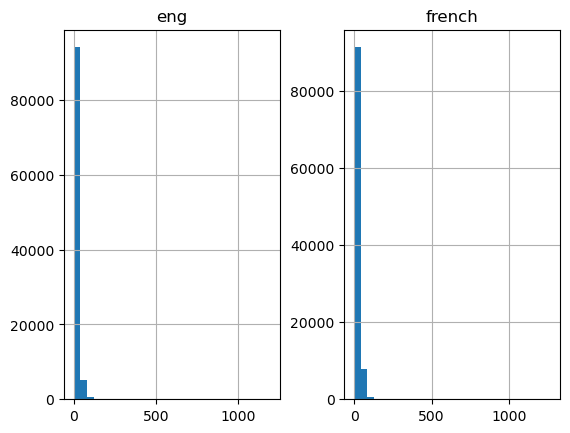

In [84]:
# Text to Sequence Conversion

'''
    A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.
    But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in 
    two separate lists for English and French, respectively.

'''

# empty lists
eng_l = []
fren_l = []

set_eng = set()
set_fren = set()

# populate the lists with sentence lengths
m = 0
for sentence in df['en']:   
    tmp = sentence.split(' ')
    eng_l.append(len(tmp))
    for j in tmp:        
        set_eng.add(j)       
    if len(tmp) > m:
        m = len(tmp)

for sentence in df['fr']:   
    tmp = sentence.split(' ')
    fren_l.append(len(tmp))
    for j in tmp:        
        set_fren.add(j)       
    if len(tmp) > m:
        m = len(tmp)

length_df = pd.DataFrame({'eng':eng_l, 'french':fren_l})
length_df.hist(bins = 30)
plt.show()

In [85]:
# Max length of englist sentence is 
max(eng_l)

1191

In [86]:
# Max length of french sentence is 
max(fren_l)

1265

In [87]:
# empty lists
eng_l = []
fren_l = []

set_eng = set()
set_fren = set()

for index,row in df.iterrows():   
    eng_words = row['en'].split(' ')
    fren_words = row['fr'].split(' ')
    if len(eng_words) <= MAX_SENT_LENGTH and len(fren_words) <= MAX_SENT_LENGTH:
        eng_l.append(len(eng_words))
        fren_l.append(len(fren_words))
        for j in eng_words:        
            set_eng.add(j)    
        for j in fren_words:        
            set_fren.add(j)    

# New Max length of sentences
print('New Max length of english sentence is {}'.format(max(eng_l)))
print('New Max length of French sentence is {}'.format(max(fren_l)))

New Max length of english sentence is 40
New Max length of French sentence is 40


In [88]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer
    
# prepare english tokenizer
eng_tokenizer = tokenization(set_eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1 

# prepare bengali tokenizer
fren_tokenizer = tokenization(set_fren)
fren_vocab_size = len(fren_tokenizer.word_index) + 1 

In [89]:
eng_vocab_size

55622

In [90]:
fren_vocab_size

67746

In [91]:
from sklearn.model_selection import train_test_split

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df['fr'], df['en'], test_size=0.2, random_state=42)

In [92]:
#The below code block contains a function to prepare the sequences. It will also perform sequence padding 
# to a maximum sentence length as mentioned above.

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [93]:
# Let us save the actual output of testing data before encoding
test_op = y_test

# encode training data
X_train = encode_sequences(fren_tokenizer, max(fren_l), X_train)
y_train = encode_sequences(eng_tokenizer, max(eng_l), y_train)

# encode validation/test data
X_test = encode_sequences(fren_tokenizer, max(fren_l), X_test)
y_test = encode_sequences(eng_tokenizer, max(eng_l), y_test)

In [ ]:
# These predictions are sequences of integers. We need to convert these integers to their corresponding 
# words. Let’s define a function to do this:

token_dict_english = {}

def create_and_save_eng_encoding():
    for word, index in eng_tokenizer.word_index.items():
        token_dict_english[index] = word
        
    json_object = json.dumps(token_dict_english, indent=4)
    with open(MODEL_PATH+"token_dict_english.json", "w") as outfile:
        outfile.write(json_object)

token_dict_french = {}
def create_and_save_fren_encoding():    
    for word, index in fren_tokenizer.word_index.items():
        token_dict_french[index] = word
        
    json_object = json.dumps(token_dict_french, indent=4)
    with open(MODEL_PATH+"token_dict_french.json", "w") as outfile:
        outfile.write(json_object)

 
create_and_save_eng_encoding()
create_and_save_fren_encoding()

In [ ]:
'''
    We’ll start off by defining our Seq2Seq model architecture:

    For the encoder, we will use an embedding layer and an LSTM layer
    For the decoder, we will use another LSTM layer followed by a dense layer

'''


# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model
    

'''
    We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural 
    networks.

''' 
# model compilation
model = define_model(fren_vocab_size, eng_vocab_size,max(fren_l), max(eng_l),  512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')   

In [ ]:
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(X_train, y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
                    epochs=100, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

#Let’s compare the training loss and the validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
#Finally, we can load the saved model and make predictions on the unseen data – testX.

model = load_model(filename)

In [45]:
def convert_to_words(sentence,dictionary):
    temp = ''
    for i in sentence:
        if i in dictionary:
           temp += dictionary[i]+' '
    return temp.strip()


In [ ]:
predict_x = model.predict(X_test)
print(predict_x.shape)

In [ ]:
# As we get a probability distribution, we have to take the argmax in order to determine the actual 
# prediction.
preds = []
for i in predict_x:
    tmp = []
    for j in i:
        tmp.append(np.argmax(j, axis=0))
    preds.append(tmp)

In [ ]:

preds_text = []
for i in preds:
    preds_text.append(convert_to_words(i, token_dict_english))

In [ ]:
# Now let us see how we did
pred_df = pd.DataFrame({'actual' : test_op, 'predicted' : preds_text})
pred_df.to_csv(MODEL_PATH+'actual_vs_predicted.csv')

In [ ]:
# Let us check our prediction
pred_df

In [95]:
'''
    In case of a failure, exception due to resource exhaustion, we can still use the saved model and the encoding dictionary to 
    do the prediction.
'''
X_train = None
y_train = None
X_test = X_test[:10]
test_op = test_op[:10]
df = None

def load_json_file(file_abs_path):
    try:        
        with open(file_abs_path, 'r') as f:
          data = json.load(f)
        return data
    except:
        return {}
    

#def load_model_and_predict():
token_dict_english = load_json_file(MODEL_PATH+'token_dict_english.json')    
model = load_model(MODEL_PATH+MODEL_NAME)

predict_x = model.predict(X_test)
model = None

preds = []
for i in predict_x:
    tmp = []
    for j in i:
        tmp.append(np.argmax(j, axis=0))
    preds.append(tmp)    
predict_x  = None

preds_text = []
for i in preds:
    preds_text.append(convert_to_words(i, token_dict_english))

# Now let us see how we did
pred_df = pd.DataFrame({'actual' : test_op, 'predicted' : preds_text})
pred_df.to_csv(MODEL_PATH+'actual_vs_predicted.csv')
print(pred_df)
    
#load_model_and_predict()

1/1 [==============================] - 2s 2s/step
                                                  actual predicted
33969  High saving tendencies by EU consumers has als...          
24613  Compared to 2004 consumers spent 21 % more on ...          
42678      If you are already registered please continue          
9733   Philippine BSE/Meat Inspection Mission to Cana...          
7130   Stier Group Ltd Stier Group Building 12 Tversk...          
1402   To understand how light is created we must fir...          
47828  Merchandising programs focused on presenting n...          
9695   FOOD AND HOTEL ASIA 2008 - RECRUITMENT It is n...          
7127   Although local currency payments are generally...          
93405          National Office for Victims Backgrounder:          


In [68]:
y_test

33969    High saving tendencies by EU consumers has als...
24613    Compared to 2004 consumers spent 21 % more on ...
42678        If you are already registered please continue
9733     Philippine BSE/Meat Inspection Mission to Cana...
7130     Stier Group Ltd
Stier Group Building
12 Tversk...
                               ...                        
49935    Customs authorities accept the value of the sh...
81079    Inventory Tracking Goes High-Tech
 [ 2007-01-2...
45554                      Brazil Country Commercial Guide
22641    In 1993 for instance Agropur entered into a st...
13569    Below are brief profiles of three well-known K...
Name: en, Length: 20000, dtype: object

In [74]:
X = df['fr']
print(X)

0         a transformé notre vie   a transformé la soci...
1                                             Plan du site
2                                              Rétroaction
3                                                  Crédits
4                                                  English
                               ...                        
99995    ◦ Karen Bron Directrice par intérim Direction ...
99996    [ Page précédente  Table des matières  Page su...
99997    ◦ Mise en œuvre de l'article 41 de la Loi sur ...
99998    Assurer un rapprochement des communautés et un...
99999    • Continuer d'organiser et de dispenser un cou...
Name: fr, Length: 99998, dtype: object
